In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchaudio import load, transforms
import librosa
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import os
import glob
import numpy as np

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [25]:
tf = transforms.MFCC(sample_rate=8000)

def normalize(tensor):
    tensor_minusmean = tensor - tensor.mean()
    return tensor_minusmean / tensor_minusmean.max()

In [62]:
class WavDataset(Dataset):
    def __init__(self, data_folder, length=300000, transform=None):
        self.data_folder = data_folder
        self.dim = length
        self.wav_list = []
        self.transform = transform

        formats = [".wav", ".WAV"]
        for root, dirnames, filenames in os.walk(data_folder):
            for filename in filenames:
                if os.path.splitext(filename)[1] in formats:
                    label = str(root).split("/")[-1]
                    self.wav_list.append([os.path.join(root, filename), label])

        
    def __getitem__(self, item):
        filename, label = self.wav_list[item]
        wb_wav, sr = load(filename)
        wb_wav = wb_wav[[0], :] # 单声道

        length = len(wb_wav)
        if length >= self.dim:
               max_audio_start = length - self.dim
               audio_start = np.random.randint(0, max_audio_start)
               wb_wav = wb_wav[audio_start: audio_start + self.dim]
        else:
            wb_wav = F.pad(wb_wav, (0, self.dim - length), "constant")
        
        if self.transform is not None:
            wb_wav = normalize(self.transform(wb_wav))

        return wb_wav, sr, filename, label
 
    def __len__(self):
        return len(self.wav_list)


In [63]:
train_set= WavDataset("datasets/train/")
test_set = WavDataset("datasets/test/")

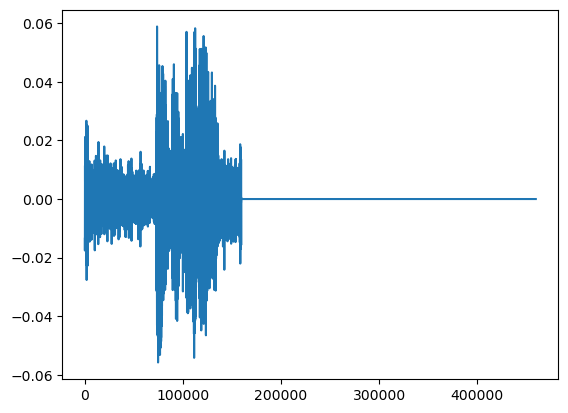

In [64]:
wavform, sr, name, label = train_set[0]
plt.plot(wavform.t().numpy());

In [65]:
labels = sorted(list(set(datapoint[-1] for datapoint in train_set)))
print(labels)

['JSY', 'WX', 'WZH', 'XXL']


In [66]:
new_sample_rate = 8000

transform   = transforms.Resample(orig_freq=sr, new_freq=new_sample_rate)
transformed = transform(wavform)

ipd.Audio(transformed, rate=new_sample_rate)

In [67]:
def label_to_index(word):
    return torch.tensor(labels.index(word))

def index_to_label(index):
    return labels[index]

word_start = "WX"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

WX --> tensor(1) --> WX


In [68]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch] # 将Tensor进行转置
    # 用0填充张量至等长度，.pad_sequence()用法可参考：https://blog.csdn.net/qq_38251616/article/details/125222012
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)

def collate_fn(batch):
    # A data tuple has the form:
    # wb_wav, sr, filename, label
    tensors, targets = [], []
    # Gather in lists, and encode labels as indices
    for waveform, *_, label in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)
    return tensors, targets

batch_size = 2

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [69]:
next(iter(test_loader))

(tensor([[[0.0036, 0.0053, 0.0056,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0025, 0.0031, 0.0027,  ..., 0.0000, 0.0000, 0.0000]]]),
 tensor([0, 0]))

In [70]:
for X, y in test_loader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([2, 1, 460703])
Shape of y:  torch.Size([2]) torch.int64


In [71]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)

model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=4, bias=True)
)
Number

In [72]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10


In [73]:
losses = []
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data   = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data   = transform(data)
        output = model(data)

        # 计算 loss
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 打印训练进度
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # 记录 loss
        losses.append(loss.item())

In [74]:
# 计算预测正确的数目
def number_of_correct(pred, target):
    return pred.squeeze().eq(target).sum().item()

# 找到最有可能的标签
def get_likely_index(tensor):
    return tensor.argmax(dim=-1)

def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

In [76]:
log_interval = 100  # 每100个batch打印一次训练结果
n_epoch = 5

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)

for epoch in range(1, n_epoch + 1):
    train(model, epoch, log_interval)
    test(model, epoch)
    scheduler.step()

Train Epoch: 1 [0/4 (0%)]	Loss: 1.100255

Test Epoch: 1	Accuracy: 2/8 (25%)

Train Epoch: 2 [0/4 (0%)]	Loss: 1.035932

Test Epoch: 2	Accuracy: 2/8 (25%)

Train Epoch: 3 [0/4 (0%)]	Loss: 1.212343

Test Epoch: 3	Accuracy: 2/8 (25%)

Train Epoch: 4 [0/4 (0%)]	Loss: 0.932949

Test Epoch: 4	Accuracy: 1/8 (12%)

Train Epoch: 5 [0/4 (0%)]	Loss: 0.964167

Test Epoch: 5	Accuracy: 0/8 (0%)



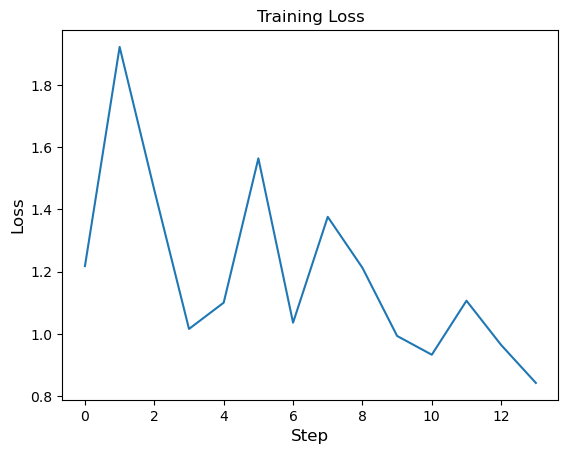

In [77]:
plt.plot(losses)
plt.xlabel("Step", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training Loss")
plt.show()